In [1]:
from keras.datasets import mnist
import numpy as np

%matplotlib inline


from time import time, sleep
import matplotlib.pyplot as plt
from IPython import display

from sklearn.metrics import accuracy_score

(X_train, y_train), (X_test, y_test) = mnist.load_data()
mean = 255./2
X_train = (X_train.astype('float32') - mean) / 255.
X_test  = (X_test .astype('float32')- mean) / 255.

X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)


Using TensorFlow backend.


In [2]:
# print(y_train)
from keras.utils import to_categorical
def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

y_train = encode(y_train)
y_test = encode(y_test)

print(y_train)
print(y_test)


Shape of data (BEFORE encode): (60000,)
Shape of data (AFTER  encode): (60000, 10)

Shape of data (BEFORE encode): (10000,)
Shape of data (AFTER  encode): (10000, 10)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [3]:

def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1


In [4]:
# (re-)load layers
%run homework_modules.ipynb


In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-4, 'momentum': 0.9}
optimizer_state = {}

# Looping params
batch_size = 500

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]


In [7]:
import sys

def train(net, X_train, y_train, X_test, y_test, n_epoch = 10, isPrint=False):
    loss_history = []
    accuracy_history = []
    loss_history_test = []
    accuracy_history_test = []
    
    for i in range(n_epoch):
        loss_batch = []
        accuracy_batch = []

        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
            net.zeroGradParameters()
            # Forward
            predictions = net.forward(x_batch)
            accuracy = accuracy_score(np.argmax(predictions, axis=1), np.argmax(y_batch, axis=1))
            loss = criterion.forward(predictions, y_batch)
            
            
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
        
            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      
                        
            loss_batch.append(loss)
            accuracy_batch.append(accuracy)

        loss_test_batch = []
        accuracy_test_batch = []
        for x_batch, y_batch in get_batches((X_test, y_test), batch_size):
            predictions_test = net.forward(x_batch)
            accuracy_test = accuracy_score(np.argmax(y_batch, axis=1), np.argmax(predictions_test, axis=1))
            loss_test = criterion.forward(predictions_test, y_batch)
            loss_test_batch.append(loss_test)
            accuracy_test_batch.append(accuracy_test)
        
        loss = np.array(loss_batch).mean()
        accuracy = np.array(accuracy_batch).mean()
        loss_test = np.array(loss_test_batch).mean()
        accuracy_test = np.array(accuracy_test_batch).mean()
                                            
        if isPrint:
            sys.stdout.write('Epoch: {4} Train: {0:3f} {1:3f} Test: {2:3f} {3:3f} \n'.format(loss, accuracy, loss_test, accuracy_test, i ))
    
        loss_history.append(loss)
        accuracy_history.append(accuracy)
        loss_history_test.append(loss_test)
        accuracy_history_test.append(accuracy_test)

            
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss reb - test: blue - train")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.plot(loss_history_test, 'r')
    plt.show()
    
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training accuracy")
    plt.xlabel("#iteration")
    plt.ylabel("accuracy reb - test: blue - train")
    plt.plot(accuracy_history, 'b')
    plt.plot(accuracy_history_test, 'r')
    plt.show()
    
    print("final loss", loss_history_test[-1])
    return accuracy_history_test[-1]



# Первая нейронка
Для начала попробуем 3-слойную модель с переходами от размерности 784 до 196,от 196 до 49 и от 49 до 10, чтобы обеспечить плавный переход от размерности 784 до 10.
Для начала попробуем в качестве критерия cходимости MSE


In [8]:



# (re-)load layers
%run homework_modules.ipynb

test_acs = []


In [9]:

net = Sequential()
net.add(Linear(28 * 28, 14 * 14))
net.add(LeakyReLU())
net.add(Linear(14* 14, 7 * 7))
net.add(LeakyReLU())
net.add(Linear(7 * 7, 10))
net.add(LeakyReLU())

criterion = MSECriterion()


Train ....


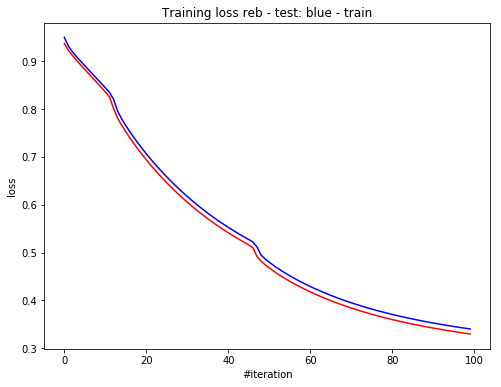

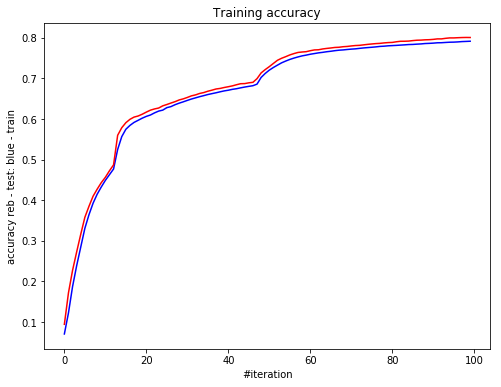

final loss 0.3297647277571731
0.8006


In [10]:
print("Train ....")
ac1 = train(net, X_train, y_train, X_test, y_test, 100)
print(ac1)
test_acs.append(ac1)

# Вторая нейронка
Теперь в качестве критерия сходимости возьмем softmax кросэнторопию

In [21]:

# (re-)load layers
%run homework_modules.ipynb


In [22]:

net2 = Sequential()
net2.add(Linear(28 * 28, 14 * 14))
net2.add(LeakyReLU())
net2.add(Linear(14 * 14, 7 * 7))
net2.add(LeakyReLU())
net2.add(Linear(7 * 7, 10))
net2.add(LeakyReLU())

criterion = CrossentropySoftMaxCriterion()



Train ....


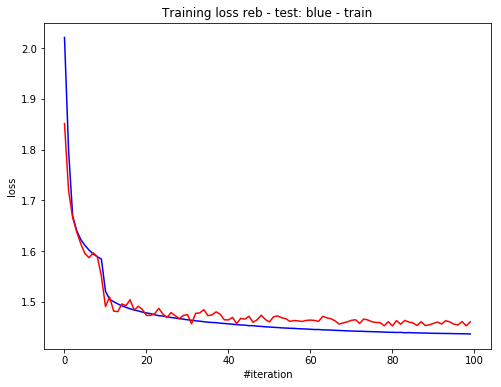

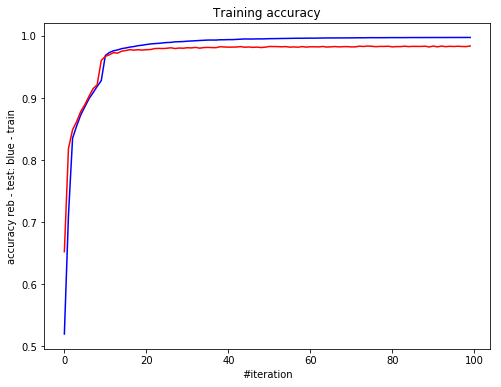

final loss 1.460489581423813
0.9838999999999999


In [23]:
print("Train ....")
ac1 = train(net2, X_train, y_train, X_test, y_test, 100)
print(ac1)
test_acs.append(ac1)


# Третья нейронка
Добавим dropout слой для предотвращения переобучения


In [14]:

# (re-)load layers
%run homework_modules.ipynb


In [15]:
net3 = Sequential()
net3.add(Linear(28 * 28, 14 * 14))
net3.add(LeakyReLU())
net3.add(Dropout())
net3.add(Linear(14 * 14, 7 * 7))
net3.add(LeakyReLU())
net3.add(Linear(7 * 7, 10))
net3.add(LeakyReLU())

criterion = CrossentropySoftMaxCriterion()


Train ....


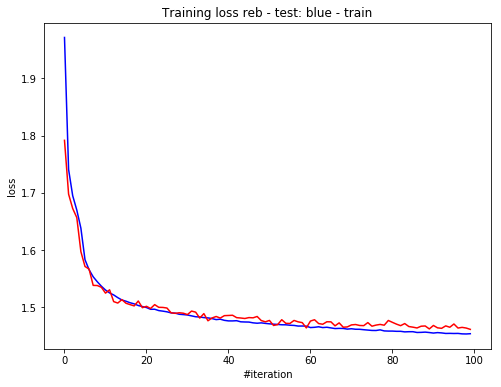

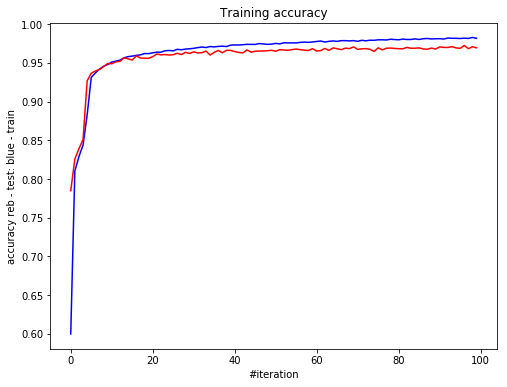

final loss 1.4614824340043469
0.9693999999999999


In [16]:
print("Train ....")
ac1 = train(net3, X_train, y_train, X_test, y_test, 100)
print(ac1)
test_acs.append(ac1)


# Четвертая нейронка
Добавим dropout слой на нижний слой нейронки и посмотрим что будет.


In [17]:

# (re-)load layers
%run homework_modules.ipynb


Train ....


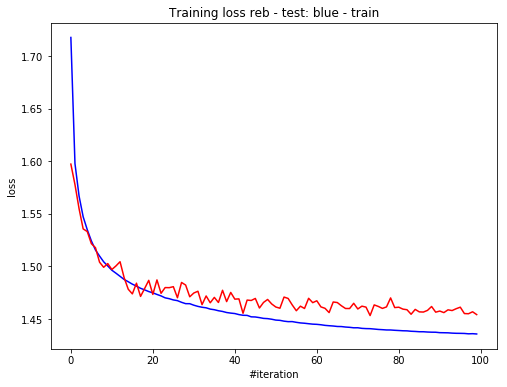

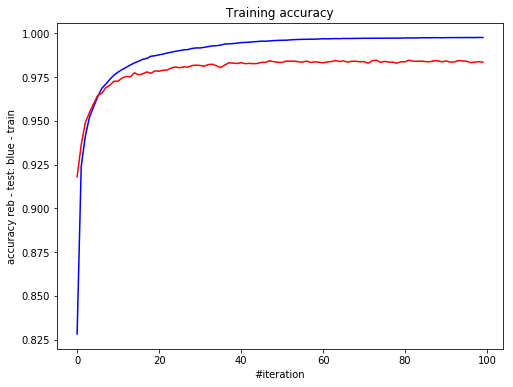

final loss 1.4542746813262883
0.9836000000000003


In [18]:

net4 = Sequential()
net4.add(Linear(28 * 28, 14 * 14))
net4.add(LeakyReLU())
net4.add(Dropout())
net4.add(Linear(14 * 14, 7 * 7))
net4.add(LeakyReLU())
net4.add(Dropout())
net4.add(Linear(7 * 7, 10))
net4.add(LeakyReLU())

criterion = CrossentropySoftMaxCriterion()
print("Train ....")
ac1 = train(net, X_train, y_train, X_test, y_test, 100)
print(ac1)
test_acs.append(ac1)


In [19]:

from tabulate import tabulate

print(tabulate([['Net1', test_acs[0]], ['Net2', test_acs[1]], ['Net3', test_acs[2]], ['Net4', test_acs[3]]], headers=['Net', 'Accuracy']))




Net      Accuracy
-----  ----------
Net1       0.8006
Net2       0.982
Net3       0.9694
Net4       0.9836


# Итог
Первая модель сошлась хуже всех, но скорее всего сошлась бы не хуже остальных, если бы ей позволили дообучиться.
Вторая модель сошлась быстрее и лучше первой.
Треться модель сошласть чуть хуже второй. По графикам видно что dropout работает. 
Четвертая модель сошласть не хуже второй. По графикам видно что dropout работает еще сильнее.
